# Kernel Set-Up

In [1]:
# executing shell commands
gpu_info = ! nvidia-smi # type: ignore

gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('NOT connected to a GPU')
else:
    print(gpu_info)

Fri Jul 19 06:46:49 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A4500               Off |   00000000:55:00.0 Off |                  Off |
| 30%   34C    P8             17W /  200W |     118MiB /  20470MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# ! pip install pytz
# ! pip install scipy
# ! pip install matplotlib

# ! pip install pandas

# ! pip install pysteps
# ! pip install opencv-python opencv-contrib-python 
# ! pip install opencv-python-headless opencv-contrib-python-headless
# ! apt-get install ffmpeg libsm6 libxext6 -y
# ! pip install scikit-image

# ! pip install cartopy
# ! pip uninstall cartopy -y

In [3]:
import os
import warnings

# os.environ["XLA_FLAGS"] = "--xla_gpu_strict_conv_algorithm_picker=false"
# os.environ['CUDA'] = os.environ["LD_LIBRARY_PATH"]
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
import copy
import h5py
import time
import pytz
import keras
import pickle
import typing
import numpy as np
import datetime as dt
import tensorflow as tf
from pprint import pprint
import numpy.typing as npt
from scipy.io import loadmat
import matplotlib.pyplot as plt
from collections import OrderedDict
from keras.api.models import Model, load_model
from keras.api.layers import (
    Input, ConvLSTM2D, Conv3D, 
    MaxPooling3D, Concatenate, UpSampling3D,
    BatchNormalization, LeakyReLU, Dropout, Add
)
from pysteps.motion.lucaskanade import dense_lucaskanade
from pysteps.visualization.motionfields import motion_plot
from pysteps.extrapolation.semilagrangian import extrapolate


Pysteps configuration file found at: /usr/local/lib/python3.11/dist-packages/pysteps/pystepsrc



In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5000)]
    )

# Utility Functions

They have already been extensively in previous notebooks saved on the drive
<br>
<br>


In [6]:
def h5_to_np(file_path: str | None, target_var: str) -> npt.NDArray[np.float64]:    # return NDArray shape is (400, 400)
    """
    Generic function that takes any target variable from the
    MOSDAC library and builds a numpy array after co-locating
    within the Indian subcontinent region.
    The function returns the values of the target variable within 
    the 0-40N Latitude, 60-100E Longitude region with a 0.1 deg resolution
    Therefore, the shape of the returned numpy array is (400, 400)

    NOTE: if file_path is None, the function returns a NDArray of zeroes of 
    the same shape as the expected output.
    """

    if file_path is None:
        # return NDArray shape is (400, 400)
        return np.zeros((400, 400))

# in case I have introduced a bug in the previous functions
    if not os.path.exists(file_path):
        raise IOError(f"File {file_path} not found")

# extracting information
    cur_file = h5py.File(file_path)

    lat = cur_file['Latitude'][()] * 0.01
    lon = cur_file['Longitude'][()] * 0.01

    var = np.squeeze(cur_file[target_var][()])

# Filter data within location of interest
    lat_filtered = lat[(lat >= 0) & (lat < 40) & (lon >= 60) & (lon < 100)]
    lon_filtered = lon[(lat >= 0) & (lat < 40) & (lon >= 60) & (lon < 100)]
    var_filtered = var[(lat >= 0) & (lat < 40) & (lon >= 60) & (lon < 100)]

# Grid data from 0-40N Latitude, 60-100E Longitude with 0.1 deg resolution
    var_grid = np.zeros((400, 400))
    cnt = np.zeros((400, 400))

# Generating index values
    lat_ind = np.int32((lat_filtered - 0) * 10)
    lon_ind = np.int32((lon_filtered - 60) * 10)

    np.add.at(var_grid, (lat_ind, lon_ind), var_filtered)
    np.add.at(cnt, (lat_ind, lon_ind), 1)

    var_grid[cnt > 0] = var_grid[cnt > 0] / cnt[cnt > 0]
    var_grid[cnt == 0] = np.nan

    assert var_grid.shape == (400, 400)

    return var_grid

In [7]:
def find_by_date(
    start_datetime: dt.datetime, 
    end_datetime: dt.datetime,
    root_path: str, 
    fn_pattern: str, fn_ext: str,
    timestep: int, error: int = 2,
    upper: bool = True, lower: bool = False, 
    verbose: bool = False
) -> tuple[list[str | None], list[dt.datetime]]:
    """
    start_datetime -> must be in the datetime format (inclusive of time)
    end_datetime   -> must be in the datetime format (inclusive of time)
    root_path      -> the path to the folder where all the files are stored
    fn_pattern     -> the general name of the file with the datetime pattern (strformat) embedded
    fn_ext         -> extension of the file, do NOT include the '.'
    timestep       -> in minutes,,, the time difference between two consecutive files
    error          -> in minutes,,, if the files are not exactly in a regular timestep, add the usual error (2 means +1, +2 min AND -1, -2 min)
    upper          -> convert the filename into upper case (some stupid thing with format)
    lower          -> convert the filename into lower case (added because just upper was weird)
    verbose        -> prints all the files not found

    NOTE: defaults are set up to work with satellite data from MOSDAC

    ##
    if the filename for a particular timestamp is None,
    the file does not exist
    ##
    """

# error handling
    if upper and lower:
        raise ValueError("Cannot have both arguments, 'upper' and 'lower' be True!")

    if timestep <= 0 or isinstance(timestep, float):
        raise ValueError("Argument 'timestep' can only be a positive integer")

    if not os.path.exists(root_path):
        raise IOError("Path provided in the 'root_path' argument does not exist")
    
    if start_datetime >= end_datetime:
        raise ValueError("Argument 'start_datetime' must be less than 'end_datetime'")


    filenames = []
    timestamps = []

    cur_datetime = start_datetime

    while cur_datetime <= end_datetime:
        fn = _find_matching_fn(
            cur_datetime, root_path, fn_pattern, fn_ext, error,
            upper, lower, verbose
        )

        filenames.append(fn)
        timestamps.append(cur_datetime)

    # iterating through the datetimes
        cur_datetime = cur_datetime + dt.timedelta(minutes=timestep)

# this error exists because verbose might be false
    if all(filename is None for filename in filenames):
        raise IOError(f"No input data found in {root_path} with the given datetime range")

    return filenames, timestamps


def _find_matching_fn(
    cur_datetime, root_path, fn_pattern, fn_ext, error,
    upper, lower, verbose
):

# without error (timestep)
    fn = _gen_fn_path(
        cur_datetime,
        root_path, fn_pattern, fn_ext,
        upper, lower
    )

    if os.path.exists(fn):
        return fn

# with negative error
    for i in range(1, error+1):
        fn = _gen_fn_path(
            cur_datetime - dt.timedelta(minutes=i),
            root_path, fn_pattern, fn_ext,
            upper, lower
        )
        if os.path.exists(fn):
            return fn

# with positive error
    for i in range(1, error+1):
        fn = _gen_fn_path(
            cur_datetime + dt.timedelta(minutes=i),
            root_path, fn_pattern, fn_ext,
            upper, lower
        )
        if os.path.exists(fn):
            return fn

# nothing matched
    if verbose:
        error_date = dt.datetime.strftime(cur_datetime, fn_pattern)
        if upper:
            error_date = error_date.upper()
        if lower:
            error_date = error_date.lower()

        print(f"file not found with datetime: {error_date}")

    return None


def _gen_fn_path(
    cur_datetime, root_path, fn_pattern, fn_ext,
    upper, lower
):
    fn = dt.datetime.strftime(cur_datetime, fn_pattern)

    if upper:
        fn = fn.upper()
    if lower:
        fn = fn.lower()

    fn = fn + '.' + fn_ext
    fn = os.path.join(root_path, fn)

    return fn


In [8]:
def olr_norm(arr):
    return (arr - 50) / 330

def olr_denorm(arr):
    return (arr * 330) + 50

# MAX of OLR is 380
# MIN of OLR is 50

## Metrics

for evaluation and loss

In [9]:
# implementing olr_denorm using tensorflow functions
@keras.saving.register_keras_serializable()
class DenormMSELoss(tf.keras.Loss):
    def call(self, y_true, y_pred):
        # not using the olr_denorm function because it cannot be turned into a tf.function
        denorm_y_true = (y_true * 330) + 50
        denorm_y_pred = (y_pred * 330) + 50

        return tf.reduce_mean(tf.square(denorm_y_true - denorm_y_pred), axis=-1)

@keras.saving.register_keras_serializable()
class DenormMAELoss(tf.keras.Loss):
    def call(self, y_true, y_pred):
        denorm_y_true = (y_true * 330) + 50
        denorm_y_pred = (y_pred * 330) + 50

        return tf.reduce_mean(tf.math.abs(denorm_y_true - denorm_y_pred), axis=-1)

# TODO: NotImplemented Correctly
@keras.saving.register_keras_serializable()
class DenormLogCoshLoss(tf.keras.Loss):
    def call(self, y_true, y_pred):
        denorm_y_true = (y_true * 330) + 50
        denorm_y_pred = (y_pred * 330) + 50

        error = denorm_y_true - denorm_y_pred
        return tf.reduce_mean(tf.math.log((tf.math.exp(error) + tf.math.exp(-error)) / 2), axis=-1)

        ## gives rise to inf value, instead using different formula
        # tf.reduce_mean(tf.math.log(tf.math.cosh(denorm_y_true - denorm_y_pred)), axis=-1)

In [10]:
@keras.saving.register_keras_serializable()
class DenormMAE(tf.keras.Metric):
    def __init__(self, name='denorm_mae', **kwargs):
        super(DenormMAE, self).__init__(name=name, **kwargs)
        self.total = self.add_weight(name='total', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        denorm_y_true = (y_true * 330) + 50
        denorm_y_pred = (y_pred * 330) + 50

        mae = tf.reduce_mean(tf.abs(denorm_y_true - denorm_y_pred))

        self.total.assign_add(mae)
        self.count.assign_add(1)

    def result(self):
        return self.total / self.count

    def reset_states(self):
        self.total.assign(0)
        self.count.assign(0)

@keras.saving.register_keras_serializable()
class DenormMSE(tf.keras.Metric):
    def __init__(self, name='denorm_mse', **kwargs):
        super(DenormMSE, self).__init__(name=name, **kwargs)
        self.total = self.add_weight(name='total', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        denorm_y_true = (y_true * 330) + 50
        denorm_y_pred = (y_pred * 330) + 50

        mse = tf.reduce_mean(tf.square(denorm_y_true - denorm_y_pred))

        self.total.assign_add(mse)
        self.count.assign_add(1)

    def result(self):
        return self.total / self.count

    def reset_states(self):
        self.total.assign(0)
        self.count.assign(0)

@keras.saving.register_keras_serializable()
class DenormRMSE(tf.keras.Metric):
    def __init__(self, name='denorm_rmse', **kwargs):
        super(DenormRMSE, self).__init__(name=name, **kwargs)
        self.total = self.add_weight(name='total', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        denorm_y_true = (y_true * 330) + 50
        denorm_y_pred = (y_pred * 330) + 50

        rmse = tf.sqrt(tf.reduce_mean(tf.square(denorm_y_true - denorm_y_pred)))

        self.total.assign_add(rmse)
        self.count.assign_add(1)

    def result(self):
        return self.total / self.count

    def reset_states(self):
        self.total.assign(0)
        self.count.assign(0)

@keras.saving.register_keras_serializable()
class DenormPSNR(tf.keras.Metric):
    def __init__(self, name='denorm_psnr', **kwargs):
        super(DenormPSNR, self).__init__(name=name, **kwargs)
        self.total = self.add_weight(name='total', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        denorm_y_true = (y_true * 330) + 50
        denorm_y_pred = (y_pred * 330) + 50

        mse = tf.reduce_mean(tf.square(denorm_y_true - denorm_y_pred))

        # 380 is the max value of OLR
        # below is a way to calculate log_10 using only ln
        psnr = 10 * (tf.math.log(380**2 / mse) / tf.math.log(tf.constant(10, dtype=mse.dtype)))

        self.total.assign_add(psnr)
        self.count.assign_add(1)

    def result(self):
        return self.total / self.count
    
    def reset_states(self):
        self.total.assign(0)
        self.count.assign(0)

# TODO: NotImplemented Correctly
@keras.saving.register_keras_serializable()
class DenormLogCosh(tf.keras.Metric):
    def __init__(self, name='denorm_logcosh', **kwargs):
        super(DenormLogCosh, self).__init__(name=name, **kwargs)
        self.total = self.add_weight(name='total', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        denorm_y_true = (y_true * 330) + 50
        denorm_y_pred = (y_pred * 330) + 50
        
        error = denorm_y_true - denorm_y_pred
        logcosh = tf.reduce_mean(tf.math.log((tf.math.exp(error) + tf.math.exp(-error)) / 2))

        self.total.assign_add(logcosh)
        self.count.assign_add(1)

    def result(self):
        return self.total / self.count

    def reset_states(self):
        self.total.assign(0)
        self.count.assign(0)



# Data Processing

## Pre-Processing

### Functions

In [11]:

def h5_to_np_dir(
    h5_dir_path: str, target_var: str,
    h5_start_date: dt.datetime, h5_end_date: dt.datetime,
    h5_filename_fmt: str, h5_timestep: int,
    np_dir_path: str, np_filename_fmt: str 
) -> None:
    """
    Function that takes a directory path,
    reads all the files that lie within a certain 
    datetime range and then convert it to numpy array.
    This conversion is only for the MOSDAC satellite data files,
    specifically tested with INSAT-3D data.

    The numpy arrays are stored (as npy files) in np_dir_path with the
    np_filename_fmt to describe its filename in terms of datetime.

    Also refer to the find_by_date function for more details on certain arguments
    """

# error handling
    if not os.path.isdir(np_dir_path):
        raise IOError(
            "Path provided in the 'np_dir_path' argument does not exist or is not a directory"
        )
    if not os.path.isdir(h5_dir_path):
        raise IOError(
            "Path provided in the 'h5_dir_path' argument does not exist or is not a directory"
        )


    h5_filenames, h5_timestamps = find_by_date(
        h5_start_date, h5_end_date,
        h5_dir_path, h5_filename_fmt, 'h5',
        h5_timestep
    )

    for fn, ts in zip(h5_filenames, h5_timestamps):
        print(f"\rProcessing {ts}...", end="")
        
        np_fn = os.path.join(
            np_dir_path, dt.datetime.strftime(ts, np_filename_fmt)
        )

        if fn is None or os.path.exists(np_fn):
            continue

        np_arr = h5_to_np(fn, target_var)
        np.save(np_fn, np_arr, fix_imports=False)

    print(f"\rwritten and/or verifed (existence of) {np_dir_path} files")

In [12]:
def window_np_files_to_dir(
    npy_dir_path: str, 
    npy_filename_fmt: str,
    window_dir_path: str,
    window_filename_fmt: str,
    window_start_date: dt.datetime,
    window_end_date: dt.datetime,
    input_window_range: int,
    output_window_range: int,
    timestep: int = 30,
    input_window_frames: None | list[int] = None,
    output_window_frames: None | list[int] = None,
) -> None:
    """
    npy_dir_path            -> the path to the directory containing the numpy files (frames)
    window_dir_path         -> the path to the directory where the windowed files will be stored
    window_start_date       -> the starting date for the files to start windowing
    window_end_date         -> the ending date for the files to end windowing, no frame can be 
                            greater than this date
    input_window_range       -> the range of the input window
    output_window_range      -> the range of the output window
    timestep                -> in minutes,,, the time difference between two consecutive frames
    input_window_frames     -> the frames to be included in the input window, 
                            if None, all frames are included.
                            must only contain integers between [0, input_window_range)
    output_window_frames    -> the frames to be included in the output window,
                            if None, all frames are included.
                            must only contain integers between [0, output_window_range)


    NOTE: the frames will be stored in-order, if data is missing, within input or output window,
    the window will not be made.
    The windowed files are named after the first frame in the (input) window.
    The output window starts after the largest frame in the input window ends.
        if the largest frame of the input window is indexed on 12, 
        the output window starts from index 13
    """

# error handling
    if not os.path.isdir(npy_dir_path):
        raise IOError(
            "Path provided in the 'npy_dir_path' argument does not exist or is not a directory"
        )
    if not os.path.isdir(window_dir_path):
        raise IOError(
            "Path provided in the 'window_dir_path' argument does not exist or is not a directory"
        )
    
    if input_window_frames is not None:
        if not all(0 <= frame_ind < input_window_range for frame_ind in input_window_frames):
            raise ValueError("All elements in 'input_window_frames' must be within [0, input_window_range)")
    else:
        input_window_frames = list(range(input_window_range))
    
    if output_window_frames is not None:
        if not all(0 <= frame_ind < output_window_range for frame_ind in output_window_frames):
            raise ValueError("All elements in 'output_window_frames' must be within [0, output_window_range)")
    else:
        output_window_frames = list(range(output_window_range))

    
    input_window_size = len(input_window_frames)
    output_window_size = len(output_window_frames)

# caching
    cache = OrderedDict()
    def cached_load(fn: str) -> npt.NDArray[np.float64]:        # return NDArray shape is (400, 400)
        max_cache_size = input_window_range + output_window_range + 5
        while len(cache) > max_cache_size:
            cache.popitem(last=False)
        
        try:
            frame = cache[fn]
        except KeyError:
            frame = np.load(fn)
            cache[fn] = frame

        assert frame.shape == (400, 400)
        return frame


    npy_filenames, npy_timestamps = find_by_date(
        window_start_date, window_end_date,
        npy_dir_path, npy_filename_fmt, 'npy',
        timestep, 0, False
    )
    
    max_index_addition_for_window = (max(input_window_frames) + 1) + max(output_window_frames)
    for i, (fn, ts) in enumerate(zip(npy_filenames, npy_timestamps)):
        if i + max_index_addition_for_window >= len(npy_filenames):
            break

        print(f"\rProcessing {ts}...", end="")
        
        window_fn = os.path.join(
            window_dir_path, dt.datetime.strftime(ts, window_filename_fmt)
        )
        if os.path.exists(window_fn):
            continue

        input_window_fn = []
        output_window_fn = []
        for input_frame in input_window_frames:
            cur_frame = i + input_frame
            input_window_fn.append(npy_filenames[cur_frame])
        
        for output_frame in output_window_frames:
            # the +1 is because the output frame is always after the input window
            # if input window ends on 12, then ouput window indexing starts from 13
            cur_frame = i + (max(input_window_frames) + 1) + output_frame
            output_window_fn.append(npy_filenames[cur_frame])

        if any(fn is None for fn in input_window_fn) or any(fn is None for fn in output_window_fn):
            continue
        
        assert len(input_window_fn) == input_window_size
        assert len(output_window_fn) == output_window_size
        assert fn == input_window_fn[0]

        input_window = np.stack([cached_load(fn) for fn in input_window_fn], axis=0)
        output_window = np.stack([cached_load(fn) for fn in output_window_fn], axis=0)

        assert input_window.shape == (input_window_size, 400, 400)
        assert output_window.shape == (output_window_size, 400, 400)

        window = np.concatenate([input_window, output_window], axis=0)
        assert window.shape == (input_window_size + output_window_size, 400, 400)

        np.save(window_fn, window, fix_imports=False)

    print(f"\rwritten and/or verifed (existence of) {window_dir_path} files")

In [13]:
def normalize_olr_window(
    window_arr: npt.NDArray[np.float64],
    min_max_scale: bool = True,
    add_channel_dim: bool = True,
    nan_impute: None | str = 'conv_mean',
    cval: float = 0.,
    kernel_size: int = 3,
) -> npt.NDArray[np.float64]:
    """
    window_arr      -> must be of shape (None, 400, 400) where None represents any integer
    min_max_scale   -> if True, the OLR values are clipped between [50, 350] and 
                        then scaled MinMax scaled between 0 and 1.
                        This operation occurs after imputation (if imputation is happening).
    add_channel_dim -> if True, the channel dimension is added to the array, for convolutional models
    nan_impute      -> the method to impute the NaN values in the array
                    None          -> no imputation
                    'mean'        -> impute with the mean of the frame
                    'median'      -> impute with the median of the frame
                    'cval'        -> impute with a constant value
                    'conv_mean'   -> impute with the mean of the kernel centered at the NaN value
                    'conv_median' -> impute with the median of the kernel centered at the NaN value
    cval            -> the constant value to impute NaN values with, not used if nan_impute is not 'cval'
    kernel_size     -> the size of the kernel to use for convolutional imputation,
                        can only be odd positive integers greater than 1
                        not used if nan_impute is not 'conv_mean' or 'conv_median'

    NOTE: convolution does not fill out the values at the edge of the frame, it 
    just considers a smaller kernel for the edge values.
    """
    
    assert window_arr.shape == (window_arr.shape[0], 400, 400)

    match nan_impute:
        case None:
            pass
        
        case 'mean':
            temp_arr = np.zeros_like(window_arr)
            for i in range(window_arr.shape[0]):
                temp_arr[i] = np.where(np.isnan(window_arr[i]), np.nanmean(window_arr[i]), window_arr[i])
            window_arr = temp_arr
        
        case 'median':
            temp_arr = np.zeros_like(window_arr)
            for i in range(window_arr.shape[0]):
                temp_arr[i] = np.where(np.isnan(window_arr[i]), np.nanmedian(window_arr[i]), window_arr[i])
            window_arr = temp_arr
        
        case 'cval':
            window_arr = np.where(np.isnan(window_arr), cval, window_arr)
        
        case 'conv_mean':
            assert kernel_size % 2 == 1 and kernel_size > 1
            temp_arr = np.zeros_like(window_arr)
            for i in range(window_arr.shape[0]):
                temp_arr[i] = _conv_mean_fillna(window_arr[i], kernel_size)
            window_arr = temp_arr

        case 'conv_median':
            assert kernel_size % 2 == 1 and kernel_size > 1
            temp_arr = np.zeros_like(window_arr)
            for i in range(window_arr.shape[0]):
                temp_arr[i] = _conv_median_fillna(window_arr[i], kernel_size)
            window_arr = temp_arr

        case _:
            raise ValueError(
                "Argument 'nan_impute' must be one of [None, 'mean', 'median', 'cval', 'conv_mean', 'conv_median']"
            )
        
    if min_max_scale:
        window_arr = np.clip(window_arr, 50, 380)
        window_arr = olr_norm(window_arr)

    if add_channel_dim:
        window_arr = window_arr[..., np.newaxis]

    return window_arr


def _conv_mean_fillna(
    arr: npt.NDArray[np.float64], kernel_size: int,
    verbose: bool = False
) -> npt.NDArray[np.float64]:

    assert arr.shape == (400, 400)

    temp_arr = np.copy(arr)
    for i in range(400):
        for j in range(400):
            if np.isnan(arr[i, j]):
                increase_kernel_size = 0
                kernel = None
                while increase_kernel_size < 10:
                    i_start = max(0, i - ((kernel_size + increase_kernel_size) // 2))
                    i_end = min(400, i + ((kernel_size + increase_kernel_size) // 2) + 1)
                    j_start = max(0, j - ((kernel_size + increase_kernel_size) // 2))
                    j_end = min(400, j + ((kernel_size + increase_kernel_size) // 2) + 1)

                    kernel = arr[i_start:i_end, j_start:j_end]
                    if not np.isnan(kernel).all():
                        break
                    else:
                        increase_kernel_size += 2

                temp_arr[i, j] = np.nanmean(kernel)

                if verbose and increase_kernel_size:
                    print("kernel size:", (kernel_size + increase_kernel_size - 2))

    assert temp_arr.shape == arr.shape
    assert not np.isnan(temp_arr).any(), f"kernel-values:\n{kernel}\nkernel-idx: {i_start}, {i_end}; {j_start}, {j_end}"

    return temp_arr

def _conv_median_fillna(
    arr: npt.NDArray[np.float64], kernel_size: int,
    verbose: bool = False
) -> npt.NDArray[np.float64]:

    assert arr.shape == (400, 400)

    temp_arr = np.copy(arr)
    for i in range(400):
        for j in range(400):
            if np.isnan(arr[i, j]):
                increase_kernel_size = 0
                kernel = None
                while increase_kernel_size < 10:
                    i_start = max(0, i - ((kernel_size + increase_kernel_size) // 2))
                    i_end = min(400, i + ((kernel_size + increase_kernel_size) // 2) + 1)
                    j_start = max(0, j - ((kernel_size + increase_kernel_size) // 2))
                    j_end = min(400, j + ((kernel_size + increase_kernel_size) // 2) + 1)

                    kernel = arr[i_start:i_end, j_start:j_end]
                    if not np.isnan(kernel).all():
                        break
                    else:
                        increase_kernel_size += 2

                temp_arr[i, j] = np.nanmedian(kernel)

                if verbose and increase_kernel_size:
                    print("kernel size:", kernel_size + increase_kernel_size - 2)

    assert temp_arr.shape == arr.shape
    assert not np.isnan(temp_arr).any(), f"kernel-values:\n{kernel}\nkernel-idx: {i_start}, {i_end}; {j_start}, {j_end}"

    return temp_arr


### Testing & Processing onto Disk

In [ ]:
## May-Sep 2022 OLR data
h5_to_np_dir(
    h5_dir_path='/mnt/data/mosdac/OLR/May-Sep2022',
    target_var='OLR',
    h5_start_date=dt.datetime(2022, 5, 1, 0, 0),
    h5_end_date=dt.datetime(2022, 9, 30, 23, 59),
    h5_filename_fmt='3DIMG_%d%b%Y_%H%M_L2B_OLR_V01R00',
    h5_timestep=30,
    np_dir_path='/home/jeet_cai/OLR_nowcasting/data/May-Sep2022_np/',
    np_filename_fmt='%Y%b%d_%H%M_3DIMG_OLR.npy'
)

## May-Sep 2023 OLR data
h5_to_np_dir(
    h5_dir_path='/mnt/data/mosdac/OLR/May-Sep2023',
    target_var='OLR',
    h5_start_date=dt.datetime(2023, 5, 1, 0, 0),
    h5_end_date=dt.datetime(2023, 9, 30, 23, 59),
    h5_filename_fmt='3DIMG_%d%b%Y_%H%M_L2B_OLR_V01R00',
    h5_timestep=30,
    np_dir_path='/home/jeet_cai/OLR_nowcasting/data/May-Sep2023_np/',
    np_filename_fmt='%Y%b%d_%H%M_3DIMG_OLR.npy'
)

In [ ]:
# windowing Jun-Jul 2022 OLR data
    # input window size is 6 frames, fully populated
    # output window size is 2 frames, at +1hr and +3hr
window_np_files_to_dir(
    npy_dir_path='/home/jeet_cai/OLR_nowcasting/data/May-Sep2022_np/',
    npy_filename_fmt='%Y%b%d_%H%M_3DIMG_OLR',
    window_dir_path='/home/jeet_cai/OLR_nowcasting/data/Jun-Jul2022_windowed/',
    window_filename_fmt='%Y%b%d_%H%M_window_6_6_None_1,5_3DIMG_OLR.npy',
    window_start_date=dt.datetime(2022, 6, 1, 0, 0),
    window_end_date=dt.datetime(2022, 7, 31, 23, 59),
    input_window_range=6,
    output_window_range=6,
    output_window_frames=[1, 5],   # ouput is one hour and three hour ahead frames
)

# windowing Jun-Jul 2023 OLR data
    # input window size is 6 frames, fully populated
    # output window size is 2 frames, at +1hr and +3hr
window_np_files_to_dir(
    npy_dir_path='/home/jeet_cai/OLR_nowcasting/data/May-Sep2023_np/',
    npy_filename_fmt='%Y%b%d_%H%M_3DIMG_OLR',
    window_dir_path='/home/jeet_cai/OLR_nowcasting/data/Jun-Jul2023_windowed/',
    window_filename_fmt='%Y%b%d_%H%M_window_6_6_None_1,5_3DIMG_OLR.npy',
    window_start_date=dt.datetime(2023, 6, 1, 0, 0),
    window_end_date=dt.datetime(2023, 7, 31, 23, 59),
    input_window_range=6,
    output_window_range=6,
    output_window_frames=[1, 5],   # output is one hour and three hour ahead frames
)


## the ouptut window frame index calculations example:
# 1 means that the frame will be corresponding to (1 + 1) * timesteps minutes ahead (from the last input frame window)
# 5 means that the frame will be corresponding to (5 + 1) * timesteps minutes ahead (from the last input frame window)

In [ ]:
# windowing Jun-Jul 2022 OLR data
    # input window size is 6 frames, fully populated
    # output window size is 6 frames, fully populated
window_np_files_to_dir(
    npy_dir_path='/home/jeet_cai/OLR_nowcasting/data/May-Sep2022_np/',
    npy_filename_fmt='%Y%b%d_%H%M_3DIMG_OLR',
    window_dir_path='/home/jeet_cai/OLR_nowcasting/data/Jun-Jul2022_windowed/',
    window_filename_fmt='%Y%b%d_%H%M_window_6_6_None_None_3DIMG_OLR.npy',
    window_start_date=dt.datetime(2022, 6, 1, 0, 0),
    window_end_date=dt.datetime(2022, 7, 31, 23, 59),
    input_window_range=6,
    output_window_range=6
)

# windowing Jun-Jul 2023 OLR data
    # input window size is 6 frames, fully populated
    # output window size is 6 frames, fully populated
window_np_files_to_dir(
    npy_dir_path='/home/jeet_cai/OLR_nowcasting/data/May-Sep2023_np/',
    npy_filename_fmt='%Y%b%d_%H%M_3DIMG_OLR',
    window_dir_path='/home/jeet_cai/OLR_nowcasting/data/Jun-Jul2023_windowed/',
    window_filename_fmt='%Y%b%d_%H%M_window_6_6_None_None_3DIMG_OLR.npy',
    window_start_date=dt.datetime(2023, 6, 1, 0, 0),
    window_end_date=dt.datetime(2023, 7, 31, 23, 59),
    input_window_range=6,
    output_window_range=6,
)


OSError: Path provided in the 'npy_dir_path' argument does not exist or is not a directory

In [ ]:
# perf test
dir_name = '/home/jeet_cai/OLR_nowcasting/data/Jun-Jul2023_windowed/'
dir_files = os.listdir(dir_name)

start_time = time.time()

for window_fn in dir_files:
    window_arr = np.load(dir_name + window_fn)
    window_arr = normalize_olr_window(window_arr, nan_impute=None)

total_time = time.time() - start_time

# this includes disk loading time, not particularly hot
print(f"time taken per window normaliation: {(total_time * 1000) / len(dir_files):.3f} milliseconds")

In [ ]:
# Data Visualisation utils

plt.rcParams["font.family"] = "monospace"
# coast = loadmat('/home/jeet_cai/OLR_nowcasting/data/coast.mat')
coast = loadmat('/home/server_jeet/OLR_nowcasting/data/coast.mat')

In [ ]:
window_fn = np.load('/home/server_jeet/OLR_nowcasting/data/Jun-Jul2022_windowed/2022Jun01_0000_window_6_6_None_None_3DIMG_OLR.npy')
norm_window = normalize_olr_window(window_fn)

fig, (ax_norm, ax) = plt.subplots(1, 2, figsize=(12, 5))

# after processing and normalization
ax_norm.plot(coast['long'], coast['lat'], 'k-')
ax_norm.set_title("Normalized OLR values", pad=10)
im_norm = ax_norm.imshow(
    norm_window[-1, ...], 
    extent=[60, 100, 0, 40], 
    origin='lower', 
    vmin=0, vmax=1,
    cmap='jet'
)
plt.colorbar(im_norm, ax=ax_norm, pad=0.075)

# before any pre-processing, raw window
ax.plot(coast['long'], coast['lat'], 'k-')
ax.set_title("Raw OLR values", pad=10)
im = ax.imshow(
    window_fn[-1, ...], 
    extent=[60, 100, 0, 40], 
    origin='lower', 
# adding clipping (kinda) for better comparison
    vmin=50, vmax=380,
    cmap='jet'
)
plt.colorbar(im, ax=ax, pad=0.075)

fig.tight_layout(w_pad=2.25)
plt.show()

## Data Generator

### Function

In [14]:
# TODO: infer the input_window_size and the output_window_size 
#       from the filename format provided.

def load_data_generator(
    batch_size: int, shuffle: bool, batch_ts: bool,
    input_window_size: int, output_window_size: int,
    start_time: dt.datetime, end_time: dt.datetime,
    dir_path: str, filename_fmt: str,
    batch_dtype: np.dtype = np.float64,
    files_by_date_params: dict[str, typing.Any] = {
        'fn_ext': 'npy',
        'timestep': 30,
        'error': 0,
        'upper': False,
    },
    olr_normalize_window_params: dict[str, typing.Any] = {}
) -> typing.Generator[
        typing.Union[
            tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]],
            tuple[npt.NDArray[np.float64], npt.NDArray[np.float64], list[dt.datetime]]
        ],
        None, None
    ]:
    """
    batch_size                  -> the number of samples in each batch
    shuffle                     -> if True, the data is shuffled before each epoch 
                                    before batching and yielding
    batch_ts                    -> if True, only x and y is returned (for a batch),
                                    else, x, y and the timestamps for the batch is returned (in the current order)
    input_window_size           -> the size of the input window
    output_window_size          -> the size of the output window
    start_time                  -> the starting datetime for when to startb looking for the files on disk
    end_time                    -> the ending datetime for when to stop looking for the files on disk
    dir_path                    -> the directory path where the files are stored
    batch_dtype                 -> the dtype of the batch arrays, only use floats,
                                    use lower precision if there is not enough memory
    filename_fmt                -> the filename format for the files
    files_by_date_params        -> the parameters to pass to the find_by_date function
    olr_normalize_window_params -> the parameters to pass to the normalize_olr_window function
    
    NOTE: refer to the find_by_date and normalize_olr_window functions for more details on the parameters
    and the start_time, end_time, dir_path, filename_fmt parameters too
    """
    
    filenames, timestamps = find_by_date(
        start_time, end_time,
        dir_path, filename_fmt, 
        **files_by_date_params
    )

    window_files, window_timestamps = None, None

    fn_cleaned, ts_cleaned = [], []
    for fn, ts in zip(filenames, timestamps):
        if fn is not None:
            fn_cleaned.append(fn)
            ts_cleaned.append(ts)

    window_files: npt.NDArray[np.str_] = np.array(fn_cleaned)
    window_timestamps: npt.NDArray[np.str_] = np.array(ts_cleaned)

    while True:
        if shuffle: 
            shuffler = np.random.permutation(len(window_files))
            window_files = window_files[shuffler]
            window_timestamps = window_timestamps[shuffler]
        
        for batch_start in range(0, len(window_files), batch_size):
            batch_files = window_files[batch_start:batch_start+batch_size]
            batch_timestamps = window_timestamps[batch_start:batch_start+batch_size]

            x = np.zeros((batch_size, input_window_size, 400, 400, 1), dtype=batch_dtype)
            y = np.zeros((batch_size, output_window_size, 400, 400, 1), dtype=batch_dtype)

            for batch_idx, window_fn in enumerate(batch_files):
                window_arr = np.load(window_fn)

            ### DEBUG ###
                try:
                    window_arr = normalize_olr_window(window_arr, **olr_normalize_window_params)
                except AssertionError as e:
                    print(f"\nAssertionError: {e}")
                    print(f"Filename: {window_fn}\nTimestamp: {batch_timestamps[batch_idx]}\n")
                    return
            ### DEBUG ###

                x[batch_idx] = window_arr[:input_window_size]
                y[batch_idx] = window_arr[input_window_size:]

                assert y.shape[1] == output_window_size

            yield (x, y, batch_timestamps) if batch_ts else (x, y)


### Testing

It takes about 0.5 seconds to process each window. 
This number can be brought further down by pre-normalizing all the data and storing it on disk, 
however, I need more flexibility as the normalization could change.

We are using the tf.data API to have easy pre-fetching to speed up the training, therefore,
the 0.5 second speed is not really a bottleneck.
<br>
<br>

In [ ]:
# perf test

batch_size = 5
dir_path = '/home/jeet_cai/OLR_nowcasting/data/Jun-Jul2022_windowed/'
assert len(os.listdir(dir_path)) % batch_size != 0

start_time = time.time()

for n_batches, (x, y, batch_ts) in enumerate(load_data_generator(
    batch_size=batch_size,
    shuffle=True,
    batch_ts=True,
    input_window_size=6,
    output_window_size=6,
    start_time=dt.datetime(2022, 6, 1, 0, 0),
    end_time=dt.datetime(2022, 7, 31, 23, 59),
    dir_path=dir_path,
    filename_fmt='%Y%b%d_%H%M_window_6_6_None_None_3DIMG_OLR',
)):
    if len(batch_ts) != batch_size:
        break
    print(f"\rProcessed {n_batches + 1} batches...\t\tx_shape:{x.shape};y_shape:{y.shape}", end="")

total_time = time.time() - start_time

print(f"\rtime taken per batch: {total_time / (n_batches + 1):.3f} seconds")


## Problem Frames ##
# Timestamp: 2022-06-06 01:30:00
# Timestamp: 2022-06-06 02:00:00
# Timestamp: 2022-06-06 03:30:00
# Timestamp: 2022-06-06 05:00:00
# Timestamp: 2022-06-06 05:30:00
# Timestamp: 2022-06-06 06:00:00
# Timestamp: 2022-06-06 07:00:00

## Transferred all the windows where the bottom right corner, has a lot of NaN values
## no way to impute them, even when the kernel size is 25x25, therefore just removing those windows,

# to ever use these windows again, transfer them from data/bad_data to the appropriate directory


# Model Architecture

In [15]:
def resnet_block(input_layer, num_filters):
    conv1 = ConvLSTM2D(
        num_filters,
        kernel_size=3,
        activation='relu',
        padding='same',
        return_sequences=True
    )(input_layer)
    
    batch1 = BatchNormalization()(conv1)
    
    conv2 = ConvLSTM2D(
        num_filters, 
        kernel_size=3, 
        activation='relu', 
        padding='same', 
        return_sequences=True
    )(batch1)
    batch2 = BatchNormalization()(conv2)
    dropout = Dropout(0.2)(batch2)
    
    shortcut = ConvLSTM2D(
        num_filters, 
        kernel_size=1, 
        padding='same',
        return_sequences=True
    )(input_layer)
    added = Add()([shortcut, dropout])
    
    return added


In [16]:
def unet_resnet(
    pretrained_weights=None, 
    input_size=(6, 400, 400, 1)
):
    inputs = Input(input_size)

    conv1 = resnet_block(inputs, 32)
    pool1 = MaxPooling3D(pool_size=(1, 2, 2))(conv1)

    conv2 = resnet_block(pool1, 64)
    pool2 = MaxPooling3D(pool_size=(1, 2, 2))(conv2)

    conv3 = resnet_block(pool2, 128)
    pool3 = MaxPooling3D(pool_size=(1, 2, 2))(conv3)

    conv4 = resnet_block(pool3, 256)

    up5 = Concatenate()([UpSampling3D(size=(1, 2, 2))(conv4), conv3])
    conv5 = resnet_block(up5, 128)

    up6 = Concatenate()([UpSampling3D(size=(1, 2, 2))(conv5), conv2])
    conv6 = resnet_block(up6, 64)

    up7 = Concatenate()([UpSampling3D(size=(1, 2, 2))(conv6), conv1])
    conv7 = resnet_block(up7, 32)

    conv8 = Conv3D(
        filters=8, 
        kernel_size=(3, 3, 3), 
        activation='tanh', 
        padding='same'
    )(conv7)

    conv9 = Conv3D(
        filters=1, 
        kernel_size=(3, 3, 3), 
        activation='tanh', 
        padding='same'
    )(conv8)

    model = Model(inputs, conv9)

    if pretrained_weights is not None:
        model.load_weights(pretrained_weights)

    return model

In [17]:
def encoder_decoder_resnet(
    pretrained_weights=None,
    input_size=(6, 400, 400, 1)
):
    inputs = Input(input_size)

    conv1 = resnet_block(inputs, 32)
    pool1 = MaxPooling3D(pool_size=(1, 2, 2))(conv1)

    conv2 = resnet_block(pool1, 64)
    pool2 = MaxPooling3D(pool_size=(1, 2, 2))(conv2)

    conv3 = resnet_block(pool2, 128)

    up4 = UpSampling3D(size=(1, 2, 2))(conv3)
    conv4 = resnet_block(up4, 64)

    up5 = UpSampling3D(size=(1, 2, 2))(conv4)
    conv5 = resnet_block(up5, 32)

    conv6 = Conv3D(
        filters=8,
        kernel_size=(1, 3, 3),
        activation='tanh',
        padding='same'
    )(conv5)

    conv7 = Conv3D(
        filters=1,
        kernel_size=(1, 3, 3),
        activation='tanh',
        padding='same'
    )(conv6)

    model = Model(inputs, conv7)

    if pretrained_weights is not None:
        model.load_weights(pretrained_weights)

    return model

In [18]:
def encoder_decoder(
    pretrained_weights=None,
    input_size=(6, 400, 400, 1)
):
    inputs = Input(input_size)

    conv1 = ConvLSTM2D(
        filters=32,
        kernel_size=(3, 3),
        activation='relu',
        padding='same',
        return_sequences=True,
    )(inputs)
    batch_norm1 = BatchNormalization()(conv1)
    pool1 = MaxPooling3D((1, 2, 2))(batch_norm1)

    conv2 = ConvLSTM2D(
        filters=64,
        kernel_size=(3, 3),
        activation='relu',
        padding='same',
        return_sequences=True,
    )(pool1)
    pool2 = MaxPooling3D((1, 2, 2))(conv2)

    conv3 = ConvLSTM2D(
        filters=128,
        kernel_size=(3, 3),
        activation='relu',
        padding='same',
        return_sequences=True,
    )(pool2)
    batch_norm3 = BatchNormalization()(conv3)
    pool3 = MaxPooling3D((1, 2, 2))(batch_norm3)

    conv4 = ConvLSTM2D(
        filters=128,
        kernel_size=(3, 3),
        activation='relu',
        padding='same',
        return_sequences=True,
    )(pool3)
    batch_norm4 = BatchNormalization()(conv4)
    up4 = UpSampling3D((1, 2, 2))(batch_norm4)

    conv5 = ConvLSTM2D(
        filters=64,
        kernel_size=(3, 3),
        activation='relu',
        padding='same',
        return_sequences=True,
    )(up4)
    batch_norm5 = BatchNormalization()(conv5)
    up5 = UpSampling3D((1, 2, 2))(batch_norm5)

    conv6 = ConvLSTM2D(
        filters=32,
        kernel_size=(3, 3),
        activation='relu',
        padding='same',
        return_sequences=True,
    )(up5)
    batch_norm6 = BatchNormalization()(conv6)
    up6 = UpSampling3D((1, 2, 2))(batch_norm6)

    conv7 = Conv3D(
        filters=8,
        kernel_size=(1, 3, 3),
        activation='tanh',
        padding='same'
    )(up6)

    conv8 = Conv3D(
        filters=1,
        kernel_size=(1, 3, 3),
        activation='tanh',
        padding='same'
    )(conv7)

    model = Model(inputs, conv8)

    if pretrained_weights is not None:
        model.load_weights(pretrained_weights)

    return model

In [19]:
# i honestly am not entirely sure why this is the way it is
# like every single aspect of this has not been meticulously thought of
# shit was thrown at the wall and this one stuck on the wall for the
# longest amount of time


def encoder_decoder_old(
    pretrained_weights=None,
    input_size=(6, 400, 400, 1)
):
    inp = Input(input_size)

    ########## encoder ##########

    # 1st ConvLSTM layer
    x = ConvLSTM2D(
        filters=64,
        kernel_size=(3, 3),
        padding='same',
        return_sequences=True,
        data_format='channels_last'
    )(inp)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)

    # Store the output for skip connection
    skip_connection_1 = x

    x = MaxPooling3D(
        pool_size=(1, 2, 2)
    )(x)  # Temporal dimension remains unchanged

    # 2nd ConvLSTM layer
    x = ConvLSTM2D(
        filters=128,
        kernel_size=(3, 3),
        padding='same',
        return_sequences=True,
        data_format='channels_last'
    )(x)
    x = LeakyReLU()(x)
    x = MaxPooling3D(
        pool_size=(1, 2, 2)
    )(x)  # Temporal dimension remains unchanged


    ########## decoder ##########

    # 1st ConvLSTM layer in the decoder
    x = ConvLSTM2D(
        filters=128,
        kernel_size=(3, 3),
        padding='same',
        return_sequences=True,
        data_format='channels_last'
    )(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = UpSampling3D(
        size=(1, 2, 2)
    )(x)

    # 2nd ConvLSTM layer in the decoder
    x = ConvLSTM2D(
        filters=64,
        kernel_size=(3, 3),
        padding='same',
        return_sequences=True,
        data_format='channels_last'
    )(x)
    x = LeakyReLU()(x)
    x = UpSampling3D(
        size=(1, 2, 2)
    )(x)

    # Add skip connection from the first encoder layer
    x = Concatenate()([skip_connection_1, x])

    # Final Layers
    x = Conv3D(
        filters=32,
        kernel_size=(3, 3, 3),
        padding='same',
        activation='sigmoid',
        data_format='channels_last'
    )(x)

    x = Conv3D(
        filters=16,
        kernel_size=(3, 3, 3),
        padding='same',
        activation='sigmoid',
        data_format='channels_last'
    )(x)

    x = Conv3D(
        filters=1,
        kernel_size=(1, 1, 1),
        padding='same',
        activation='sigmoid',
        data_format='channels_last'
    )(x)

    model = Model(inp, x)

    if pretrained_weights is not None:
        model.load_weights(pretrained_weights)

    return model


# Training Model

In [20]:
# model = encoder_decoder_old()
model = encoder_decoder_old('/home/server_jeet/OLR_nowcasting/model_chkpts/model_15-07-24_1950/latest.weights.h5')
model.compile(
    optimizer='adam', 
    loss=DenormMSELoss(), 
    metrics=[
        DenormMAE(), DenormRMSE(), DenormPSNR(), 
        # DenormLogCosh()
    ]
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 6, 400,    │          0 │ -                 │
│ (InputLayer)        │ 400, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d         │ (None, 6, 400,    │    150,016 │ input_layer[0][0] │
│ (ConvLSTM2D)        │ 400, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 6, 400,    │          0 │ conv_lstm2d[0][0] │
│ (LeakyReLU)         │ 400, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 6, 400,    │        256 │ leaky_re_lu[0][0] │
│ (BatchNormalizatio… │ 400, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 6, 200,    │          0 │ batch_normalizat… │
│ (MaxPooling3D)      │ 200, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_1       │ (None, 6, 200,    │    885,248 │ max_pooling3d[0]… │
│ (ConvLSTM2D)        │ 200, 128)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 6, 200,    │          0 │ conv_lstm2d_1[0]… │
│ (LeakyReLU)         │ 200, 128)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 6, 100,    │          0 │ leaky_re_lu_1[0]… │
│ (MaxPooling3D)      │ 100, 128)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_2       │ (None, 6, 100,    │  1,180,160 │ max_pooling3d_1[… │
│ (ConvLSTM2D)        │ 100, 128)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 6, 100,    │          0 │ conv_lstm2d_2[0]… │
│ (LeakyReLU)         │ 100, 128)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 100,    │        512 │ leaky_re_lu_2[0]… │
│ (BatchNormalizatio… │ 100, 128)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling3d       │ (None, 6, 200,    │          0 │ batch_normalizat… │
│ (UpSampling3D)      │ 200, 128)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_3       │ (None, 6, 200,    │    442,624 │ up_sampling3d[0]… │
│ (ConvLSTM2D)        │ 200, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 6, 200,    │          0 │ conv_lstm2d_3[0]… │
│ (LeakyReLU)         │ 200, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling3d_1     │ (None, 6, 400,    │          0 │ leaky_re_lu_3[0]… │
│ (UpSampling3D)      │ 400, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 6, 400,    │          0 │ batch_normalizat… │
│ (Concatenate)       │ 400, 128)         │            │ up_sampling3d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 6, 400,    │    110,624 │ concatenate[0][0

 Total params: 2,783,297 (10.62 MB)

 Trainable params: 2,782,913 (10.62 MB)

 Non-trainable params: 384 (1.50 KB)

In [21]:
# Use tf.data API to get easy multithreading and prefetching

# train_dir_path = '/home/jeet_cai/OLR_nowcasting/data/Jun-Jul2022_windowed/'
train_dir_path = '/home/server_jeet/OLR_nowcasting/data/Jun-Jul2022_windowed/'
train_start_time = dt.datetime(2022, 6, 1, 0, 0)
train_end_time = dt.datetime(2022, 7, 31, 23, 59)

# val_dir_path = '/home/jeet_cai/OLR_nowcasting/data/Jun-Jul2023_windowed/'
val_dir_path = '/home/server_jeet/OLR_nowcasting/data/Jun-Jul2023_windowed/'
val_start_time = dt.datetime(2023, 6, 1, 0, 0)
val_end_time = dt.datetime(2023, 6, 30, 23, 59)

file_fmt = '%Y%b%d_%H%M_window_6_6_None_None_3DIMG_OLR'

# epochs = 12 - 2
epochs = 12
batch_size = 3

def train_data_loader():
    return load_data_generator(
        batch_size=batch_size,
        shuffle=True,
        batch_ts=False,
        input_window_size=6,
        output_window_size=6,
        start_time=train_start_time,
        end_time=train_end_time,
        dir_path=train_dir_path,
        filename_fmt=file_fmt,
        batch_dtype=np.float32,
    )
train_data_gen = tf.data.Dataset.from_generator(
    train_data_loader,
    output_signature=(
        tf.TensorSpec(shape=(batch_size, 6, 400, 400, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(batch_size, 6, 400, 400, 1), dtype=tf.float32)
    )
)

def val_data_loader():
    return load_data_generator(
        batch_size=batch_size,
        shuffle=True,
        batch_ts=False,
        input_window_size=6,
        output_window_size=6,
        start_time=val_start_time,
        end_time=val_end_time,
        dir_path=val_dir_path,
        filename_fmt=file_fmt,
        batch_dtype=np.float32
    )
val_data_gen = tf.data.Dataset.from_generator(
    val_data_loader,
    output_signature=(
        tf.TensorSpec(shape=(batch_size, 6, 400, 400, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(batch_size, 6, 400, 400, 1), dtype=tf.float32)
    )
)


num_train_windows = sum(
    1 for fn in 
    find_by_date(
        train_start_time, train_end_time,
        train_dir_path, file_fmt, 'npy',
        30, 0, False, False, False
    )[0]
    if fn is not None
)
num_val_windows = sum(
    1 for fn in 
    find_by_date(
        val_start_time, val_end_time,
        val_dir_path, file_fmt, 'npy',
        30, 0, False, False, False
    )[0]
    if fn is not None
)


In [22]:
# remove all the empty model_chkpt folders
while True:
    delete_folders = False
    folders = list(os.walk('/home/server_jeet/OLR_nowcasting/model_chkpts'))[1:]
    for subfolder_path, subfolder_folders, subfolder_files in folders:
        if not (subfolder_files or subfolder_folders):
            os.rmdir(subfolder_path)
            delete_folders = True

    if not delete_folders:
        break

# create new model_chkpt folder
model_file_name = dt.datetime.strftime(
    dt.datetime.now(pytz.timezone('Asia/Kolkata')), 'model_%d-%m-%y_%H%M.keras'
)
os.mkdir(f'/home/server_jeet/OLR_nowcasting/model_chkpts/{model_file_name[:-6]}')


In [23]:
callbacks = [
    tf.keras.callbacks.TerminateOnNaN(),
    tf.keras.callbacks.ReduceLROnPlateau(   # tweak all
        monitor='val_loss',
        factor=0.5,
        patience=2,
        mode='min',
        min_delta=0.001,
        min_lr=0.001
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_denorm_mae',
        patience=2,
        min_delta=0.001,     # tweak
        mode='min',
        restore_best_weights=True
    ),
    tf.keras.callbacks.BackupAndRestore(
        # backup_dir='/home/jeet_cai/OLR_nowcasting/model_chkpts/'
        backup_dir=f'/home/server_jeet/OLR_nowcasting/model_chkpts/{model_file_name[:-6]}'
    ),
    tf.keras.callbacks.ModelCheckpoint(
        # filepath=f'/home/jeet_cai/OLR_nowcasting/model_chkpts/{model_file_name}',
        filepath=f'/home/server_jeet/OLR_nowcasting/model_chkpts/{model_file_name[:-6]}/{model_file_name}',
        monitor='val_denorm_mae',
        save_best_only=True,
        save_weights_only=False,
        mode='min'
    )
]


In [24]:
training_steps = (
    (num_train_windows // batch_size) + 1 
    if (num_train_windows % batch_size) 
    else (num_train_windows // batch_size)
)
validation_steps = (
    (num_val_windows // batch_size) + 1 
    if (num_val_windows % batch_size) 
    else (num_val_windows // batch_size)
)
val_freq = 1

hist = model.fit(
    # train_data_gen.prefetch(3),
    train_data_gen.prefetch(tf.data.AUTOTUNE),
    steps_per_epoch=training_steps,
    # validation_data=val_data_gen.prefetch(3),
    validation_data=val_data_gen.prefetch(tf.data.AUTOTUNE),
    validation_steps=validation_steps,
    validation_freq=val_freq,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/12


I0000 00:00:1721195206.276016  446909 service.cc:146] XLA service 0x9972bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721195206.276051  446909 service.cc:154]   StreamExecutor device (0): NVIDIA RTX A4500, Compute Capability 8.6
E0000 00:00:1721195221.326058  446909 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1721195221.453614  446909 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


In [ ]:
model.save(f'/home/server_jeet/OLR_nowcasting/models/{model_file_name}')
with open(f'/home/server_jeet/OLR_nowcasting/models/{model_file_name[:-6]}_hist.pickle', 'wb') as f:
    pickle.dump(hist, f)

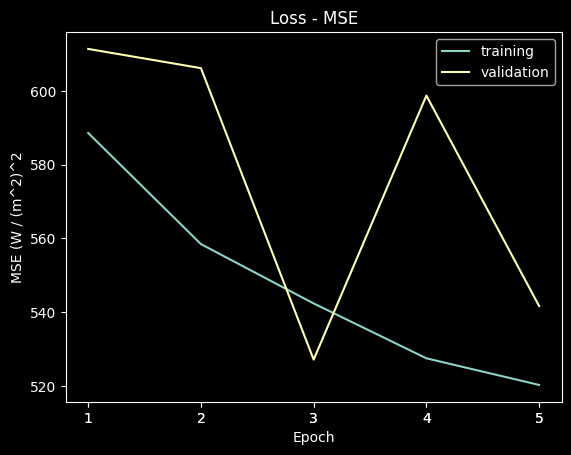

In [ ]:
training_loss = hist.history['loss']
validation_loss = hist.history['val_loss']

training_epochs = np.arange(1, len(training_loss) + 1)
validation_epochs = np.arange(val_freq, val_freq * len(validation_loss) + 1, val_freq)

training_loss = copy.deepcopy(training_loss)
training_loss.insert(0, np.inf)
validation_loss = copy.deepcopy(validation_loss)
validation_loss.insert(0, np.inf)

plt.plot(training_loss)
plt.plot(validation_loss)

plt.xticks(
    np.concatenate((training_epochs, validation_epochs)),
    labels=np.concatenate((training_epochs, validation_epochs))
)

plt.title("Loss - MSE")
plt.ylabel("MSE (W / (m^2)^2")
plt.xlabel('Epoch')
plt.legend(['training', 'validation'])

plt.show()

In [ ]:
# model.save('/home/server_jeet/OLR_nowcasting/models/model_16-07-24_0111.keras')

# Loading and Evaluating Model

## Metrics Utilities

this defines all the functions and laods the cached evaluation files

In [20]:
load_model_path = '/home/server_jeet/OLR_nowcasting/models/model_16-07-24_0111.keras'

# shouldn't need to do that with newer models due to the
# decorator that has now been put in
loaded_model: Model = load_model(
    load_model_path,
    custom_objects={
        DenormMSELoss.__name__: DenormMSELoss,
        DenormMAE.__name__: DenormMAE,
        DenormRMSE.__name__: DenormRMSE,
        DenormPSNR.__name__: DenormPSNR,
    }
)

# loaded_model = load_model(load_model_path)

In [21]:
def per_frame_denorm_mse(y_true, y_pred):
    assert y_true.shape == y_pred.shape
    assert y_true.shape == (400, 400, 1)    # ensure per frame
    
    error = olr_denorm(y_true) - olr_denorm(y_pred)
    return np.mean(error ** 2)

def per_frame_denorm_rmse(y_true, y_pred):
    assert y_true.shape == y_pred.shape
    assert y_true.shape == (400, 400, 1)    # ensure per frame
    
    error = olr_denorm(y_true) - olr_denorm(y_pred)
    return np.sqrt(np.mean(error ** 2))

def per_frame_denorm_mae(y_true, y_pred):
    assert y_true.shape == y_pred.shape
    assert y_true.shape == (400, 400, 1)    # ensure per frame
    
    error = olr_denorm(y_true) - olr_denorm(y_pred)
    return np.mean(np.abs(error))

def per_frame_denorm_psnr(y_true, y_pred):
    assert y_true.shape == y_pred.shape
    assert y_true.shape == (400, 400, 1)    # ensure per frame
    
    error = olr_denorm(y_true) - olr_denorm(y_pred)
    mse = np.mean(error ** 2)
    return 10 * (np.log10(380**2 / mse))    # max value of OLR is 380


In [22]:
def per_frame_flow_mse(y_true, y_pred):
    assert y_true.shape == y_pred.shape
    assert y_true.shape == (400, 400, 1)    # ensure per frame
    
    error = y_true - y_pred
    return np.nanmean(error ** 2)

def per_frame_flow_rmse(y_true, y_pred):
    assert y_true.shape == y_pred.shape
    assert y_true.shape == (400, 400, 1)    # ensure per frame
    
    error = y_true - y_pred
    return np.sqrt(np.nanmean(error ** 2))

def per_frame_flow_mae(y_true, y_pred):
    assert y_true.shape == y_pred.shape
    assert y_true.shape == (400, 400, 1)    # ensure per frame
    
    error = y_true - y_pred
    return np.nanmean(np.abs(error))

def per_frame_flow_psnr(y_true, y_pred):
    assert y_true.shape == y_pred.shape
    assert y_true.shape == (400, 400, 1)    # ensure per frame
    
    error = y_true - y_pred
    mse = np.nanmean(error ** 2)
    return 10 * (np.log10(380**2 / mse))    # max value of OLR is 380


In [23]:
# test_dir_path = '/home/jeet_cai/OLR_nowcasting/data/Jun-Jul2023_windowed/'
test_dir_path = '/home/server_jeet/OLR_nowcasting/data/Jun-Jul2023_windowed/'
test_start_time = dt.datetime(2023, 7, 1, 0, 0)
test_end_time = dt.datetime(2023, 7, 31, 23, 59)

file_fmt = '%Y%b%d_%H%M_window_6_6_None_None_3DIMG_OLR'

batch_size = 8

def test_data_loader():
    return load_data_generator(
        batch_size=batch_size,
        shuffle=True,
        batch_ts=False,
        input_window_size=6,
        output_window_size=6,
        start_time=test_start_time,
        end_time=test_end_time,
        dir_path=test_dir_path,
        filename_fmt=file_fmt,
        # batch_dtype=np.float32
    )

test_data_gen = tf.data.Dataset.from_generator(
    test_data_loader,
    output_signature=(
        tf.TensorSpec(shape=(batch_size, 6, 400, 400, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(batch_size, 6, 400, 400, 1), dtype=tf.float32)
    )
)

num_test_windows = sum(
    1 for fn in 
    find_by_date(
        test_start_time, test_end_time,
        test_dir_path, file_fmt, 'npy',
        30, 0, False, False, False
    )[0]
    if fn is not None
)

test_steps = (
    (num_test_windows // batch_size) + 1 
    if (num_test_windows % batch_size) 
    else (num_test_windows // batch_size)
)

test_pred_data_gen = load_data_generator(
    batch_size=1,
    shuffle=False,
    batch_ts=True,
    input_window_size=6,
    output_window_size=6,
    start_time=test_start_time,
    end_time=test_end_time,
    dir_path=test_dir_path,
    filename_fmt=file_fmt,
    # dtype=np.float32
)


In [24]:
model_metrics = {
    'mse': per_frame_denorm_mse,
    'rmse': per_frame_denorm_rmse,
    'mae': per_frame_denorm_mae,
    'psnr': per_frame_denorm_psnr
}

flow_metrics = {
    'mse': per_frame_flow_mse,
    'rmse': per_frame_flow_rmse,
    'mae': per_frame_flow_mae,
    'psnr': per_frame_flow_psnr
}

In [25]:
def per_frame_metric_average(per_frame_metric, metrics):
    """
    per_frame_metric is what is saved in the pickle file, and
    metrics is the corresponding metrics function dictionary
    """
    per_frame_metric_average = {
        # this [0, 0] will get reduced, its the sum and count per frame
        metric_name: [[0, 0] for _ in range(6)]     # assuming there are 6 frames per window
        for metric_name in metrics.keys()
    }

    for ts, metric_dict in per_frame_metric.items():
        for metric_name, metric_values in metric_dict.items():
            for frame_idx, frame_metric in enumerate(metric_values):
                per_frame_metric_average[metric_name][frame_idx][0] += frame_metric
                per_frame_metric_average[metric_name][frame_idx][1] += 1

    for metric_name, metric_values in per_frame_metric_average.items():
        for frame_idx, frame_metric in enumerate(metric_values):
            per_frame_metric_average[metric_name][frame_idx] = frame_metric[0] / frame_metric[1]

    return per_frame_metric_average


In [26]:
def per_frame_metric_time_of_day(per_frame_metric, metrics, time_of_day_spacing=30):
    """
    Ensure that the time_of_day_spacing is a factor of (24 * 60) (as spacing is in minutes)
    per_frame_metric is what is saved in the pickle file, and
    metrics is the corresponding metrics function dictionary
    """

    time_of_day = [
        dt.datetime.strftime((
                dt.datetime(1900, 1, 1, 0, 0)
                + (t * dt.timedelta(minutes=time_of_day_spacing))
            ), '%H:%M'
        )
        for t in 
        range((24 * 60) // time_of_day_spacing)
    ]
    per_frame_metric_time_of_day ={
        tod: { 
            # this [0, 0] will get reduced, its the sum and count per frame
            metric_name: [[0, 0] for _ in range(6)]     # assuming there are 6 frames per window
            for metric_name in metrics.keys() 
        } for tod in time_of_day
    }

    for ts, metric_dict in per_frame_metric.items():
        tod = str(ts.time())[:-3]
        for metric_name, metric_values in metric_dict.items():
            for frame_idx, frame_metric in enumerate(metric_values):
                per_frame_metric_time_of_day[tod][metric_name][frame_idx][0] += frame_metric
                per_frame_metric_time_of_day[tod][metric_name][frame_idx][1] += 1

    for tod, metric_dict in per_frame_metric_time_of_day.items():
        for metric_name, metric_values in metric_dict.items():
            for frame_idx, frame_metric in enumerate(metric_values):
                per_frame_metric_time_of_day[tod][metric_name][frame_idx] = frame_metric[0] / frame_metric[1]

    return per_frame_metric_time_of_day


In [27]:
with open(load_model_path[:-6] + '_per_frame_model_metric.pickle', 'rb') as pickle_file:
    per_frame_model_metric = pickle.load(pickle_file)

with open('per_frame_flow_metric.pickle', 'rb') as pickle_file:
    per_frame_flow_metric = pickle.load(pickle_file)

with open('per_frame_persistence_metric.pickle', 'rb') as pickle_file:
    per_frame_persistence_metric = pickle.load(pickle_file)

## Caching Evaluation


run the cell that you need to run in the caching evaluation after running the cells in the `Metrics Utilities` region

In [24]:
### This is not that helpful, except when testing the model saved on disk ###

# # loss is denorm_mse

# average_model_metrics = loaded_model.evaluate(
#     # test_data_gen.prefetch(3),
#     test_data_gen.prefetch(tf.data.AUTOTUNE),
#     steps=test_steps,
#     return_dict=True
# )

# # average metrics throughout the test set
# # all frames are also averaged together 
# # to get a single metric score
# pprint(average_model_metrics)

```python
per_frame__metric[timestamp] = {
    'mse': [mse(frame_true, frame_pred) for frame_true, frame_pred in zip(y_true, y_pred)],
    'rmse': [rmse(frame_true, frame_pred) for frame_true, frame_pred in zip(y_true, y_pred)],
      .
      .
      .
}
```

In [64]:
# per frame model metric score



# only need to run it once PER model

if not os.path.exists(load_model_path[:-6] + '_per_frame_model_metric.pickle'):
    # for all ts
    per_frame_model_metric = {}

    # the break condition and the bool is there due
    # to the fact that the generator is infinite
    save_first_ts = True
    first_ts = None
    for x, y_true, ts in test_pred_data_gen:
        if not save_first_ts:
            if ts[0] == first_ts:
                break

        if save_first_ts:
            first_ts = ts[0]
            save_first_ts = False


        print(f"\rPredicting for timestamp: {ts[0]}", end='')
        
        y_pred = loaded_model(x, training=False)
        per_frame_model_metric[ts[0]] = {
            metric_name: [
                metric_func(frame_true, frame_pred) 
                for frame_true, frame_pred 
                in zip(y_true[0], y_pred[0])
            ] for metric_name, metric_func in model_metrics.items()
        }

    with open(load_model_path[:-6] + '_per_frame_model_metric.pickle', 'wb') as pickle_file:
        pickle.dump(per_frame_model_metric, pickle_file)

Predicting for timestamp: 2023-07-31 18:00:00

In [37]:
# per frame flow metric score

# only need to run it once, EVER
if not os.path.exists('flow_per_frame_metric.pickle'):
    # for all ts
    per_frame_flow_metric = {}

    # the break condition and the bool is there due
    # to the fact that the generator is infinite
    save_first_ts = True
    first_ts = None
    for x, y_true, ts in test_pred_data_gen:
        if not save_first_ts:
            if ts[0] == first_ts:
                break

        if save_first_ts:
            first_ts = ts[0]
            save_first_ts = False


        print(f"\rPredicting for timestamp: {ts[0]}", end='')
        
        y_true_flow = olr_denorm(y_true[0, ...])
        x_flow = olr_denorm(x[0, ..., 0])
        
        motion_field = dense_lucaskanade(
            x_flow, dense=True, fd_method='blob',
            interp_method='rbfinterp2d'
        )
        y_pred = extrapolate(
            x_flow[-1], motion_field, timesteps=6,
            interp_order=3, return_displacement=False
        )
        y_pred_flow = y_pred[..., np.newaxis]

        per_frame_flow_metric[ts[0]] = {
            metric_name: [
                metric_func(frame_true, frame_pred) 
                for frame_true, frame_pred 
                in zip(y_true_flow, y_pred_flow)
            ] for metric_name, metric_func in flow_metrics.items()
        }

    with open('flow_per_frame_metric.pickle', 'wb') as pickle_file:
        pickle.dump(per_frame_flow_metric, pickle_file)

Predicting for timestamp: 2023-07-01 01:30:00

In [38]:
# per frame persistence metric score

# only need to run it once, EVER
if not os.path.exists('per_frame_persistence_metric.pickle'):
    # for all ts
    per_frame_persistence_metric = {}

    # the break condition and the bool is there due
    # to the fact that the generator is infinite
    save_first_ts = True
    first_ts = None
    for x, y_true, ts in test_pred_data_gen:
        if not save_first_ts:
            if ts[0] == first_ts:
                break

        if save_first_ts:
            first_ts = ts[0]
            save_first_ts = False


        print(f"\rPredicting for timestamp: {ts[0]}", end='')
        
        y_true = olr_denorm(y_true[0, ...])
        y_pred = olr_denorm(x[0, ...])
        y_pred_persistence = np.stack(tuple(([y_pred[-1, ...]] * 6)))
        assert y_pred_persistence.shape == (6, 400, 400, 1)
        assert np.array_equal(y_pred_persistence[0], y_pred_persistence[-1])

        per_frame_persistence_metric[ts[0]] = {
            metric_name: [
                metric_func(frame_true, frame_pred) 
                for frame_true, frame_pred
                in zip(y_true, y_pred_persistence)
            ] for metric_name, metric_func in flow_metrics.items()
        }

    with open('per_frame_persistence_metric.pickle', 'wb') as pickle_file:
        pickle.dump(per_frame_persistence_metric, pickle_file)

Predicting for timestamp: 2023-07-01 01:00:00

In [41]:
print("Flow Prediction Metrics (per frame):")
pprint(per_frame_metric_average(per_frame_flow_metric, flow_metrics))

print("\nModel Prediction Metrics (per frame):")
pprint(per_frame_metric_average(per_frame_model_metric, model_metrics))

print("\nPersistence Prediction Metrics (per frame):")
pprint(per_frame_metric_average(per_frame_persistence_metric, flow_metrics))

Flow Prediction Metrics (per frame):
{'mae': [9.505337782347445,
         14.026046960771268,
         17.49149803350908,
         20.332473212007525,
         22.743580644588448,
         24.878422681654474],
 'mse': [218.5723771634568,
         445.15146699697004,
         665.7018416971217,
         873.6283029016811,
         1067.479308567457,
         1251.5856530483236],
 'psnr': [28.41921254527125,
          25.213958124185,
          23.448282978243704,
          22.262989123133913,
          21.390603935005153,
          20.699707667483082],
 'rmse': [14.576219596495074,
          20.966546644409537,
          25.670562028166344,
          29.4171628076732,
          32.52207622700778,
          35.21524383777841]}

Model Prediction Metrics (per frame):
{'mae': [15.614487901958013,
         15.370004789125874,
         15.34224384863258,
         15.302716757602619,
         16.936208802621483,
         18.802764295161456],
 'mse': [489.3300471397195,
         475.52886416263

## Visualisation of Output

In [28]:
# Data Visualisation utils

plt.rcParams["font.family"] = "monospace"

# coast = loadmat('/home/jeet_cai/OLR_nowcasting/data/coast.mat')
coast = loadmat('/home/server_jeet/OLR_nowcasting/data/coast.mat')

In [29]:
def plot_window_preds(window_npy, ts, model, frames=None):
    # pre-process the window and predict y using the loaded_model
    norm_window = normalize_olr_window(window_npy)[np.newaxis, ...]   # adding the batch dimension

    x = norm_window[:, :6]
    y_true = norm_window[:, 6:]

    y_model_pred = model(x, training=False)

    # process the window further and get the flow prediction
    flow_x = olr_denorm(x)[0, ..., 0]
    motion_field = dense_lucaskanade(
        flow_x, dense=True, fd_method='blob', 
        interp_method='rbfinterp2d'
    )
    y_flow_pred = extrapolate(
        flow_x[-1], motion_field,
        timesteps=6, interp_order=3, return_displacement=False
    )

    # set up frames to plot
    if frames is None:
        frames = list(range(6))
    else:
        assert len(frames) <= 6 and len(frames) > 0
        assert len(set(frames)) == len(frames)
        assert all([type(frame) == int for frame in frames])
        assert all([0 <= frame < 6 for frame in frames])
    
    frames.sort()

    # START DRAWING FIGURE
    figsize = None
    match len(frames):
        case 1:
            figsize = (4, 14)
        case 2:
            figsize = (7.5, 14)
        case 3:
            figsize = (11, 14)
        case 4:
            figsize = (14.5, 14)
        case 5:
            figsize = (18, 14)
        case 6:
            figsize = (22, 14)   # max 6 frames

    fig, axs = plt.subplots(
        nrows=4, ncols=1, 
        figsize=figsize
    )

    # add subfigure per subplot
    for ax in axs:
        ax.remove()

    gridspec = axs[0].get_subplotspec().get_gridspec()
    subfigs = [fig.add_subfigure(gs) for gs in gridspec]

    # set up the subfigures
    truth_subfig, model_pred_subfig, flow_pred_subfig, input_subfig = subfigs

    ## truth subfigure
    truth_subfig.suptitle("Ground Truth", fontsize=18)

    truth_axs = truth_subfig.subplots(nrows=1, ncols=len(frames))
    truth_axs = [truth_axs] if len(frames) == 1 else truth_axs

    for frame, truth_ax in zip(frames, truth_axs):
        truth_ax.set_title(
            dt.datetime.strftime(
                ts + dt.timedelta(minutes=(30 * (frame + 6))), 
                '%d %b, %Y %H:%M'
            )
        )
        truth_ax.plot(coast['long'], coast['lat'], 'k-')
        truth_im = truth_ax.imshow(
            olr_denorm(y_true)[0, frame, ..., 0], 
            extent=[60, 100, 0, 40], origin='lower', 
            vmin=50, vmax=380, cmap='Greys_r'
        )

    truth_subfig.subplots_adjust(right=0.84)
    truth_cbar_ax = truth_subfig.add_axes([0.85, 0.15, 0.008, 0.7])
    truth_subfig.colorbar(truth_im, cax=truth_cbar_ax)
    truth_cbar_ax.set_ylabel("OLR   W/m^2", rotation=270, labelpad=16)

    ## model pred subfigure
    model_pred_subfig.suptitle("Model Prediction", fontsize=18)
    
    model_axs = model_pred_subfig.subplots(nrows=1, ncols=len(frames))
    model_axs = [model_axs] if len(frames) == 1 else model_axs

    for frame, pred_ax in zip(frames, model_axs):
        pred_ax.set_title(
            dt.datetime.strftime(
                ts + dt.timedelta(minutes=(30 * (frame + 6))), 
                '%d %b, %Y %H:%M'
            )
        )
        pred_ax.plot(coast['long'], coast['lat'], 'k-')
        pred_im = pred_ax.imshow(
            olr_denorm(y_model_pred)[0, frame, ..., 0], 
            extent=[60, 100, 0, 40], origin='lower', 
            vmin=50, vmax=380, cmap='Greys_r'
        )

    model_pred_subfig.subplots_adjust(right=0.84)
    model_pred_cbar_ax = model_pred_subfig.add_axes([0.85, 0.15, 0.008, 0.7])
    model_pred_subfig.colorbar(pred_im, cax=model_pred_cbar_ax)
    model_pred_cbar_ax.set_ylabel("OLR   W/m^2", rotation=270, labelpad=16)

    ## flow pred subfigure
    flow_pred_subfig.suptitle("Flow Prediction", fontsize=18)

    flow_axs = flow_pred_subfig.subplots(nrows=1, ncols=len(frames))
    flow_axs = [flow_axs] if len(frames) == 1 else flow_axs
    
    for frame, flow_ax in zip(frames, flow_axs):
        flow_ax.set_title(
            dt.datetime.strftime(
                ts + dt.timedelta(minutes=(30 * (frame + 6))), 
                '%d %b, %Y %H:%M'
            )
        )
        flow_ax.plot(coast['long'], coast['lat'], 'k-')
        flow_im = flow_ax.imshow(
            y_flow_pred[frame, ...],
            extent=[60, 100, 0, 40], origin='lower', 
            vmin=50, vmax=380, cmap='Greys_r'
        )

    flow_pred_subfig.subplots_adjust(right=0.84)
    flow_pred_cbar_ax = flow_pred_subfig.add_axes([0.85, 0.15, 0.008, 0.7])
    flow_pred_subfig.colorbar(flow_im, cax=flow_pred_cbar_ax)
    flow_pred_cbar_ax.set_ylabel("OLR   W/m^2", rotation=270, labelpad=16)

    ## input subfigure
    input_subfig.suptitle("Input Window", fontsize=18)

    input_axs = input_subfig.subplots(nrows=1, ncols=len(frames))
    input_axs = [input_axs] if len(frames) == 1 else input_axs 

    for frame, input_ax in zip(frames, input_axs):
        input_ax.set_title(
            dt.datetime.strftime(
                ts + dt.timedelta(minutes=(30 * frame)), 
                '%d %b, %Y %H:%M'
            )
        )
        input_ax.plot(coast['long'], coast['lat'], 'k-')

        if frame == (6 - 1):    # for last input frame only
            motion_plot(
                motion_field, 
                ax=input_ax, 
                geodata={
                    'x1': 60, 'y1': 0,
                    'x2': 100, 'y2': 40,
                    'yorigin': 'lower'
                }
            )

        input_im = input_ax.imshow(
            olr_denorm(x)[0, frame, ..., 0],
            extent=[60, 100, 0, 40], origin='lower', 
            vmin=50, vmax=380, cmap='Greys_r'
        )

    input_subfig.subplots_adjust(right=0.84)
    input_cbar_ax = input_subfig.add_axes([0.85, 0.15, 0.008, 0.7])
    input_subfig.colorbar(input_im, cax=input_cbar_ax)
    input_cbar_ax.set_ylabel("OLR   W/m^2", rotation=270, labelpad=16)

    plt.show()

Model metrics of the random timestamp (2023-07-28 17:30:00):
{'mae': [13.564805, 12.365582, 13.169173, 13.274744, 14.429786, 15.222248],
 'mse': [382.205, 330.00906, 381.95856, 384.56, 438.63214, 485.8455],
 'psnr': [25.772708443014103,
          26.41041325265337,
          25.775509491350462,
          25.746030868701787,
          25.174667414582128,
          24.730690180572452],
 'rmse': [19.550064, 18.166151, 19.54376, 19.6102, 20.943546, 22.041903]}

Flow metrics of the random timestamp (2023-07-28 17:30:00):
{'mae': [7.279890366905169,
         11.20509871692875,
         13.974473090932927,
         16.26566360754656,
         18.0995726397065,
         19.810892497562502],
 'mse': [137.22404486361742,
         324.50398340732,
         494.44741388981384,
         661.4753262351992,
         800.47305358179,
         944.4832184995822],
 'psnr': [30.22136976639534,
          26.483471609379098,
          24.654470834922847,
          23.390535440748046,
          22.562204764

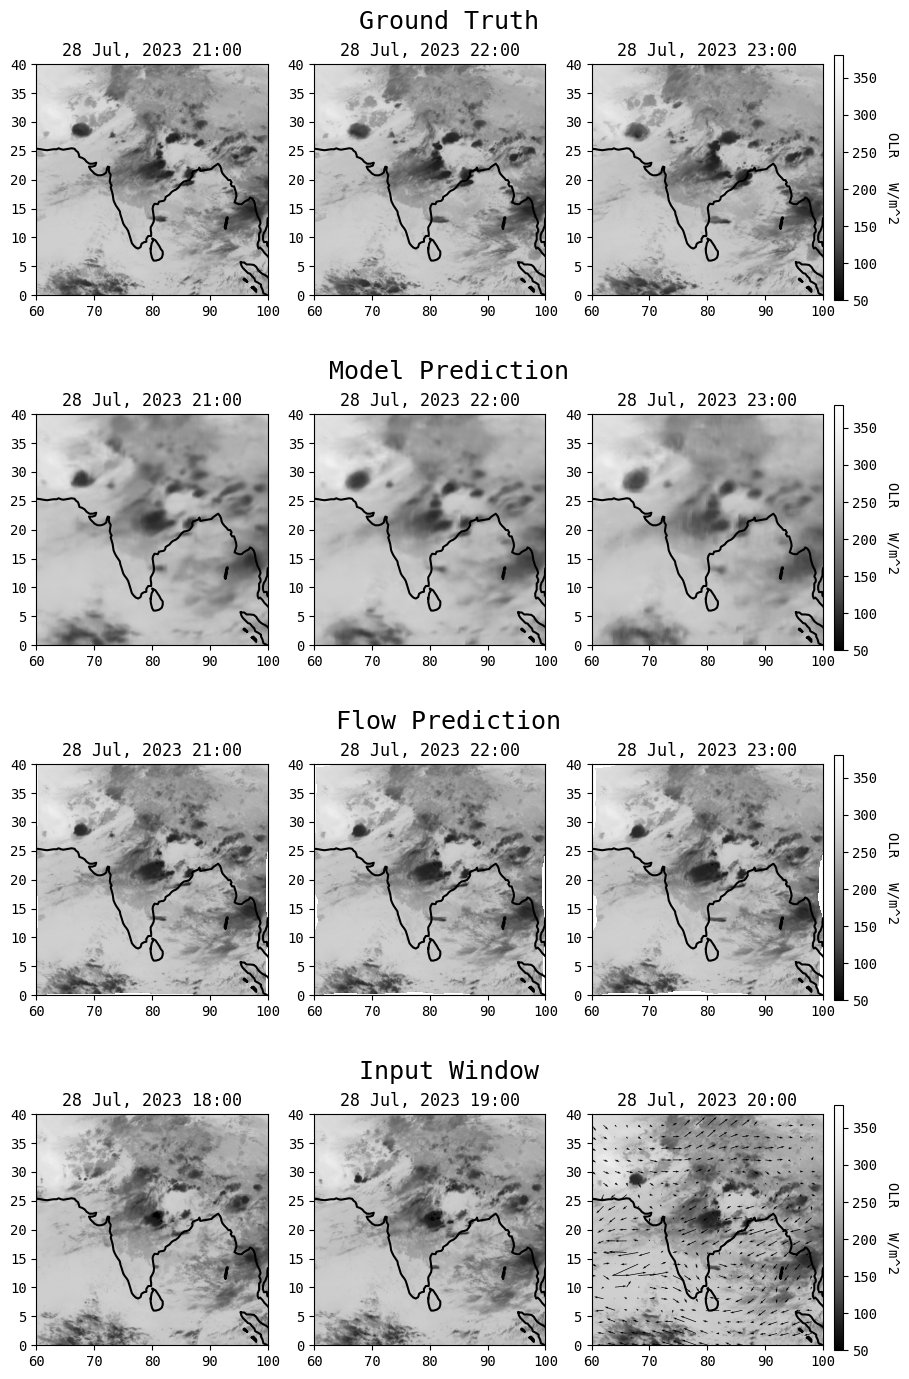

In [33]:
# currently selecting a random file to visualize (setting a seed now for consistency)
# the prediction on, and print the a metric score for the frame

# select a random window and load it
np.random.seed(420)

random_ts = np.random.choice(list(per_frame_model_metric.keys()))
random_file = f'{test_dir_path}/{dt.datetime.strftime(random_ts, file_fmt)}.npy'

print(f"Model metrics of the random timestamp ({random_ts}):")
pprint(per_frame_model_metric[random_ts])

print(f"\nFlow metrics of the random timestamp ({random_ts}):")
pprint(per_frame_flow_metric[random_ts])


random_window = np.load(random_file)
plot_window_preds(random_window, random_ts, loaded_model, [1, 3, 5])


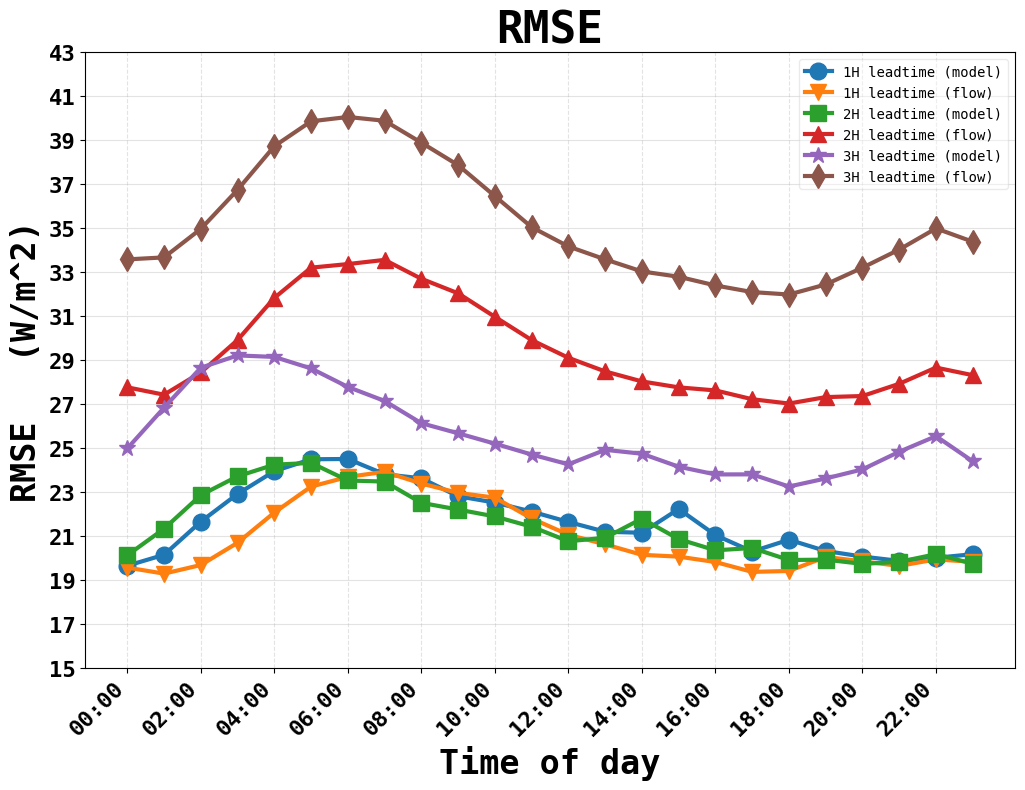

In [42]:
per_frame_model_metric_time_of_day = per_frame_metric_time_of_day(per_frame_model_metric, model_metrics)
per_frame_flow_metric_time_of_day = per_frame_metric_time_of_day(per_frame_flow_metric, flow_metrics)

frames_to_plot = [1, 3, 5]
metric = 'rmse'

ts_axis = [
    dt.datetime.strftime(
        (
            dt.datetime(1900, 1, 1, 0, 0)
            + (t * dt.timedelta(minutes=30))
        ), '%H:%M'
    )
    for t in 
    range((24 * 60) // 30)
]
markers = ['o', 'v', 's', '^', '*', 'd']

plt.figure(figsize=(12, 8))

marker_idx = 0
for frame in frames_to_plot:
    plt.plot(
        ts_axis[::2], 
        [per_frame_model_metric_time_of_day[tod][metric][frame] for tod in ts_axis][::2],
        label=f'{30 * (frame + 1) // 60:.0f}H leadtime (model)',
        marker=markers[marker_idx], markersize=12,
        linewidth=3.0
    )
    marker_idx += 1
    plt.plot(
        ts_axis[::2], 
        [per_frame_flow_metric_time_of_day[tod][metric][frame] for tod in ts_axis][::2],
        label=f'{30 * (frame + 1) / 60:.0f}H leadtime (flow)',
        marker=markers[marker_idx], markersize=12,
        linewidth=3.0
    )
    marker_idx += 1

plt.xlabel("Time of day", fontweight="bold", fontsize=24)
plt.xticks(ts_axis[::4], rotation=45, ha='right', fontweight="bold", fontsize=16)

plt.ylabel("RMSE   (W/m^2)", fontweight="bold", fontsize=24)
plt.yticks(np.arange(15, 44, 2), fontweight="bold", fontsize=16)

plt.grid(axis='x', linestyle='--', alpha=0.35)
plt.grid(axis='y', linestyle='-', alpha=0.35)
plt.legend(loc='upper right', framealpha=0.4)

plt.title("Prediction Metrics", fontweight='bold', fontsize=32)
plt.show()

# Evaulating Evaluation

In [65]:
save_dir = "/home/server_jeet/OLR_nowcasting/random_eval_check"


random_ts = np.random.choice(list(per_frame_model_metric.keys()))
random_file = f'/home/server_jeet/OLR_nowcasting/data/Jun-Jul2023_windowed/{dt.datetime.strftime(random_ts, file_fmt)}.npy'

random_window = np.load(random_file)

# pre-process the window and predict y using the loaded_model
random_norm_window = normalize_olr_window(random_window)[np.newaxis, ...]   # adding the batch dimension

random_x = random_norm_window[:, :6]
random_y_true = random_norm_window[:, 6:]

random_y_model_pred = loaded_model(random_x, training=False)

assert random_y_true.shape == random_y_model_pred.shape
assert random_y_model_pred.shape == (1, 6, 400, 400, 1)
assert np.max(random_y_model_pred) <= 1 and np.min(random_y_model_pred) >= 0    # currently normalized
assert np.max(random_y_true) <= 1 and np.min(random_y_true) >= 0                # currently normalized

# process the window further and get the flow prediction
random_flow_x = olr_denorm(random_x)[0, ..., 0]

random_motion_field = dense_lucaskanade(
    random_flow_x, dense=True, fd_method='blob', 
    interp_method='rbfinterp2d'
)
random_y_flow_pred = extrapolate(
    random_flow_x[-1], random_motion_field,
    timesteps=6, interp_order=3, return_displacement=False
)
assert random_y_flow_pred.shape == (6, 400, 400)
assert np.nanmax(random_y_flow_pred) > 50 and np.nanmin(random_y_flow_pred) > 1 # currently denormalized


# save the files as npz in the correct format
model_metrics_savefile = {
    'model_mse': per_frame_denorm_mse,
    'model_rmse': per_frame_denorm_rmse,
    'model_mae': per_frame_denorm_mae,
    'model_psnr': per_frame_denorm_psnr
}
flow_metrics_savefile = {
    'flow_mse': per_frame_flow_mse,
    'flow_rmse': per_frame_flow_rmse,
    'flow_mae': per_frame_flow_mae,
    'flow_psnr': per_frame_flow_psnr
}
save_true = olr_denorm(random_y_true)[0, ...]
save_flow_pred = random_y_flow_pred[..., np.newaxis]
save_model_pred = olr_denorm(random_y_model_pred)[0, ...]

save_model_metrics = {
    metric_name: [
        metric_func(model_frame, true_frame) 
        for model_frame, true_frame 
        in zip(olr_norm(save_model_pred), olr_norm(save_true))
    ] for metric_name, metric_func in model_metrics_savefile.items()
}

save_flow_metrics = {
    metric_name: [
        metric_func(flow_frame, true_frame) 
        for flow_frame, true_frame 
        in zip(save_flow_pred, save_true)
    ] for metric_name, metric_func in flow_metrics_savefile.items()
}

np.savez(
    f'{save_dir}/{dt.datetime.strftime(random_ts, file_fmt[:11])}_frames_metrics.npz',
    y_true=save_true, y_pred_flow=save_flow_pred, y_pred_model=save_model_pred,
    **save_model_metrics, **save_flow_metrics
)

In [74]:
# random_ts = dt.datetime(2023, 7, 24, 4, 30)

In [75]:
saved_npz = np.load(f'test_output/{dt.datetime.strftime(random_ts, file_fmt[:11])}_frames_metrics.npz')

list(saved_npz.keys())

['y_true',
 'y_pred_flow',
 'y_pred_model',
 'model_mse',
 'model_rmse',
 'model_mae',
 'model_psnr',
 'flow_mse',
 'flow_rmse',
 'flow_mae',
 'flow_psnr']

In [76]:
print(per_frame_model_metric[random_ts]['rmse'], list(saved_npz['model_rmse']), sep='\n')

[26.050882, 26.914059, 26.545843, 26.466635, 28.742899, 31.115986]

In [77]:
print(list(saved_npz['flow_rmse']))

(array([26.049654, 26.913515, 26.545662, 26.466425, 28.74306 , 31.11623 ],
       dtype=float32),
 array([16.86775048, 24.60664288, 30.59772113, 35.53632055, 39.15379529,
        41.99690707]))

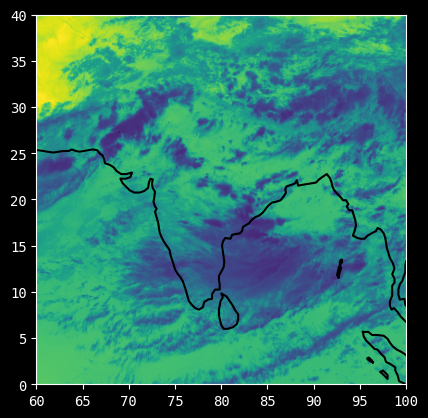

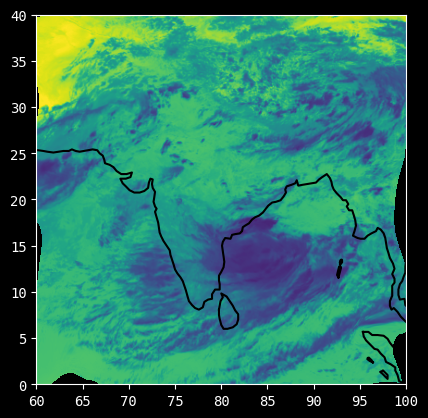

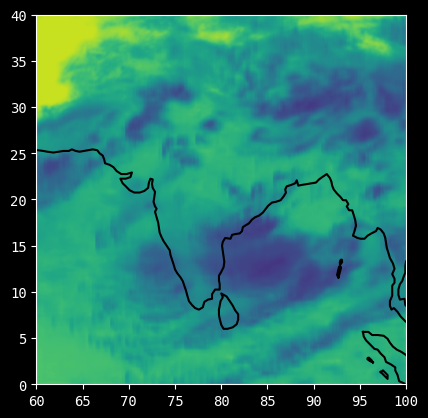

In [79]:
fig, (ax_true, ax_flow, ax_model) = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))

ax_true.set_title('Ground Truth')
ax_true.plot(coast['long'], coast['lat'], 'k-')
im = ax_true.imshow(
    saved_npz['y_true'][-1], origin='lower', 
    vmin=50, vmax=380, extent=[60, 100, 0, 40],
    cmap='Greys_r'
)

ax_flow.set_title('Flow Prediction')
ax_flow.plot(coast['long'], coast['lat'], 'k-')
ax_flow.imshow(
    saved_npz['y_pred_flow'][-1], origin='lower', 
    vmin=50, vmax=380, extent=[60, 100, 0, 40],
    cmap='Greys_r'
)

ax_model.set_title('Model Prediction')
ax_model.plot(coast['long'], coast['lat'], 'k-')
ax_model.imshow(
    saved_npz['y_pred_model'][-1], origin='lower', 
    vmin=50, vmax=380, extent=[60, 100, 0, 40],
    cmap='Greys_r'
)

fig.subplots_adjust(right=0.84)
cbar_ax = fig.add_axes([0.85, 0.15, 0.008, 0.7])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel("OLR   W/m^2", rotation=270, labelpad=16)

plt.show()